In [109]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

%matplotlib inline

In [110]:
"""Constants"""
eps0 = 8.854e-12 #[F/m]
e = 1.60217662e-19 #elementary charge [C]
h = 6.62607004e-34 #Planck's constant [Js]
m_e = 9.10938356e-31 #electron mass [kg]

In [111]:
"""Material dependant constants:"""
'''Fluid'''
fluid_density_list = [0.164, 1.205, 1.98] #He, air, CO2
eta_list = [1.96e-5, 1.81e-5, 1.47e-5] #shear viscosity = kinematic viscosity * denisty of fluid
eps_list = [eps0, eps0, 1.44*eps0] #permitivity
k_list = [1/(4*math.pi*eps_list[0]), 1/(4*math.pi*eps_list[1]), 1/(4*math.pi*eps_list[2])] 
lp_list = [17.5e-3, 6.7e-3, 4e-3]
pressure = 101.325e3
temp = 298.15
A1_list = [1.277, 1.207, 1.15]

'''QDs'''
#(InAs/GaAs QDs)
Rt = (10*h)/(e**2) #tunneling resistance (made up value)
m_eeff = 0.067 * m_e #electron effective mass [kg]
m_heff = 0.34 * m_e #hole effective mass [kg]
E_g = 0.36 * 1.60217662e-19 #band gap of QD (InAs bulk) [J]


'''Inner section'''
cap_d = 0.394    #capacitance density in [F/m^2] of inner segment capacitors
rho = 3e3 # desity of inner disc material (approxmiate) [kg/m^3]
R_c = 1 #capacitor circuit resistance

In [112]:
"""Initial parameter functions"""
def seperation_angle(n):
    return ( (2*math.pi)/n )

def setup_radius(sep, diam, PHI):
    return ( (sep + diam)/(2 * math.sin(PHI/2)) )

def cog_length( Rp, PHI):
    r = ( Rp*math.sin(PHI) )/(4*math.sin(PHI/2))
    return r

def width( Rp, PHI):
    w = ( Rp*math.sin(PHI) )/2
    return w

def inertia2 (rho, thc, r, w, Rp):
    """Calculates inertia of inner rotating section"""
    m_cog = rho*thc*w*r
    m_disc = math.pi * ((Rp-r)**2)*thc*rho
    I2 = m_cog*((r**2) + (w**2)) + 12*m_cog*((Rp-(r/2))**2) + m_disc*((Rp-r)**2)
    return I2

In [113]:
"""Motor setup functions"""

def permanent_charge_magnitude( r, width, cap_d, cap_vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (r/2) * width
    capacitance = cap_d * segment_area #capacitance of one segment
    stored_charge = capacitance * cap_vol #stored charge in one segment
    return stored_charge

def permanent_charges( Rp, p , cap_d, cap_vol, width, r):
    """Initializes permanent charge elements"""
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( r, width, cap_d, cap_vol)
        else:
            p_ch = -permanent_charge_magnitude( r, width, cap_d, cap_vol)
        PCs.update({i:[xp,yp,theta, p_ch]}) #dictionary containing all info of permanent charges
    return PCs

def quantum_dots( n, e, noc):
    """Initializes quantum dot elements"""
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, n, 4): #will result in +ve torque ==> turning anti-clockwise
            q_ch = noc*e #number of holes stored in quantum dot
        elif i in range(3, n, 4):
            q_ch = -noc*e #number of holes stored in quantum dot
        else:
            q_ch = 0 #neutral quantum dots
        QDs.update({i:[x,y,fi,q_ch]}) #dictionary containing all info on QDs
    return QDs

In [114]:
"""Friction coefficient calculator functions"""

def C(eta0, sigma, Cc):
    coef = (6*math.pi*eta0*sigma)/Cc
    return coef

def Cunningham_correction(A1, lp, pressure, temp, R):
    l = (lp * temp)/(273.15 * pressure) #mean free path
    Kn = l/R #Knudsen number
    Cc = 1 + (A1 * Kn) #only valid for Kn<0.4?
    return Cc    

def  f_t(C, eta0, N, s):
    f = 1/( (1/(N*C)) + ( s/(6*math.pi*(N**2)*eta0) ) )
    return f

def average_inverse_sum( position, N):
    i = 0
    j = 0
    s = 0
    for i in range(N):
        for j in range(N):
            if ( i == j ):
                s += 0
            else:
                r = r_ij(i, j, position)
                s += 1/r
    return s

def positions(Nx, Ny, sigma):
    position = {}
    i = 0
    j = 0
    m = 0
    for j in range(Ny):
        for i in range(Nx):
            x = sigma + 2 * i  * sigma
            y = sigma + 2 * j * sigma
            position.update({m:[x,y]})
            m += 1
    return position

def r_ij(i, j, position):
    distance = math.sqrt( ((position[i][0]-position[j][0])**2) + ((position[i][1]-position[j][1])**2) )
    return distance

def friction_function(eta, thc, width, Cc):
    """Calculates scalar frictional coefficient of one arm"""
    m = 10 #how many times calculation iterates, higher m = higher precision and accuracy but takes longer
    sigma = 5e-9 #starting radius of spheres
    sigmax = sigma/(m+2) #used to store smaller radius of spheres 
    Nx = int(width/(2*sigmax)) #number of spheres in the 'x' direction
    Ny = int(thc/(2*sigmax)) #number of spheres in the 'y' direction
    N = Nx * Ny #total number of spheres
    const = C(eta, sigmax, Cc)
    coord = positions(Nx, Ny, sigmax) #determines the positions of the centers of the spheres
    s = average_inverse_sum(coord, N)
    friction = f_t(const, eta, N, s)
    return (friction) #returns scalar frictional coefficient

In [115]:
"""Active motor functions"""

def tangential_component(k , n, e, R, Rp, gamma, noc, width, r):
    """Calculates the tangential coulomb force on one inner charge"""
    F_c = 0; #coulomb force
    F_t = 0 #tangential component of coulumb force
    QDs = quantum_dots(n, e, noc) #calls function to initialize QDs
    for i in range(n):
        Q = QDs[i] #dictionary section on ith QD
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2) #distance between QD and permanent charge edge
        ric = math.sqrt(  ( (Rp-(r/4) )**2) + (R**2) - 2*(Rp-(r/4))*R*math.cos(QDs[i][2]-gamma) ) #distance between QD and permanent charge center
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        '''Alpha is alpha at edge of permanent charge'''
        if ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) > 1 or ((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) < -1 : #accounts for computational error
            alpha = 0
        else:
            alpha = math.acos((((r0+(r/4))**2)+(ri**2)-(d**2))/(2*(r0+(r/4))*ri)) #angle to tangential in which force vector acts
        if i > n/2:
            alpha = -alpha        
        '''Alphac is alpha at center of permanent charge'''
        if ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) > 1 or ((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) < -1 : #accounts for computational error
            alphac = 0
        else:
            alphac = math.acos((((r0+(r/4))**2)+(ric**2)-(d**2))/(2*(r0+(r/4))*ric)) #angle to tangential in which force vector acts
        if i > n/2:
            alphac = -alphac
        ex_minus = ri*math.sin(alpha) - (width/2)
        ex_plus = ri*math.sin(alpha) + (width/2)
        ey_minus = ri*math.cos(alpha)
        ey_plus = ri*math.cos(alpha) + (r/2)
        sigma = PCs[0][3]/(width*r)
        f = force(ex_minus, ex_plus, ey_minus, ey_plus)
        F_c = k*sigma*Q[3]*f #coulomb force between permanent charge and QD
        F_t += F_c*math.sin(alphac)
        #if (n==80):
        #    print (PCs[0][3])
    return F_t

def force( c1, c2, c3, c4):
    a1 = (c4 + math.sqrt((c4**2)+(c1**2)))*(c3 + math.sqrt((c3**2)+(c2**2)))
    b1 = (c4 + math.sqrt((c4**2)+(c2**2)))*(c3 + math.sqrt((c3**2)+(c1**2)))
    a2 = (c2 + math.sqrt((c2**2)+(c3**2)))*(c1 + math.sqrt((c1**2)+(c4**2)))
    b2 = (c2 + math.sqrt((c2**2)+(c4**2)))*(c1 + math.sqrt((c1**2)+(c3**2)))
    I1 = math.log(a1/b1)
    I2 = math.log(a2/b2)
    f = math.sqrt( (I1**2) + (I2**2) )
    return f

def torque (F_t, Rp, p, r):
    """Computes torque on enitre inner rotor"""
    torque_radius = Rp - r/4
    torque = F_t * torque_radius * p
    return torque

def angular_velocity(angle_increment, v_ang, i, torque, inertia):
    """Calculates the angular velocity after rotating the angle increment"""
    w_f = 0
    w_f = math.sqrt( (v_ang[i])**2 + (2*torque*angle_increment)/inertia )
    return w_f

def time_step(inertia, torque, v_ang):
    """Calculates time taken to reach new v_ang"""
    tau = (v_ang[i] - v_ang[i-1])* inertia/torque
    return tau

'''def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( QDs[0][3]/(2*Cdot) ) #voltage needed to add one electron
    return voltage'''

def Charging_voltage_QD( n, e, Cdot):
    """Constant voltage required to maintain QD charge"""
    QDs = quantum_dots(n,e, noc) #calls function to initialize QDs
    voltage = ( e/(2*Cdot) ) #voltage needed to add one electron
    return voltage

def QD_capacitance( eps, d):
    Cdot = 2*math.pi*eps*d
    return Cdot

def Capacitor_charging_time( R, C):
    "Computes charging time for capacitors"
    tc = 4 * R * C
    return tc

def Dot_charging_time( Rt, Cdot):
    "Computes charging/discharging time for QDs"
    td = Rt * Cdot
    return td

def Input_energy (n, e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c):
    """Input power for each step"""
    #for capacitor charging
    E_cC = 0.5*n*PCs[0][3] * cap_vol
    #for -ve charged dots, energy corresponds to that needed to the required voltage to cause electrons to tunnel into the dot
    E_cQD = 0.5* n*Charging_voltage_QD( n, e, Cdot) * noc * e 
    #for +ve charged dots, energy corresponds to laser energy plus voltage emergy to make electrons tunnel out of the dot
    #laser energy depends on bandgap/energy level seperation
    if (noc % 2 == 0):
        J = noc/2
    else:
        J = (noc + 1)/2
    
    E_l = 0.25*n*(E_g + ((h**2)*J/(8*m_eeff*(diam**2))) + ((h**2)*J/(8*m_heff*(diam**2))))
    #print( E_cQD )
    #print( E_cC )
    E_intotal = E_l  + E_cQD + E_cC
    return E_intotal

def Output_power(angv, torque):
    return angv * torque

def Output_energy(angv, I):
    E_out = 0.5 * I * (angv**2)
    return E_out

def efficiency(E_in, E_out):
    eff = (E_out/E_in)
    return eff

In [116]:
print cap_vol

2


In [117]:
"""Mathematical functions"""

def func(x, A, B, C, D, E, F, G, H, J, K, L):
    return A * (x**10) + B * (x**9) + C * (x**8)+ D * (x**7) + E * (x**6) + F * (x**5) + G * (x**4) + H * (x**3) + J * (x**2) + K * x + L 

def solvr( Y, t, params):
    const, A, B, C, D, E, F, G, H, J, K, L = params
    return [ Y[1], ( A * (Y[0]**10) + B * (Y[0]**9) + C * (Y[0]**8)+ D * (Y[0]**7) + E * (Y[0]**6) + F * (Y[0]**5) + G * (Y[0]**4) + H * (Y[0]**3) + J * (Y[0]**2) + K * Y[0] + L - const * Y[1]) ]

In [118]:
'''Test lists'''
N = 201
startN = 12
n_list = []
p_list = []
phi_list = []
R_list = []
Rp_list = []
width_list = []
r_list = []
I_list = []
step_list = []
angle_increment_list = []
Abig_list = []
Bbig_list = []
Cbig_list = []
Dbig_list = []
Ebig_list = []
Fbig_list = []
Gbig_list = []
Hbig_list = []
Jbig_list = []
Kbig_list = []
Lbig_list = []
A_list = []
B_list = []
C_list = []
D_list = []
E_list = []
F_list = []
G_list = []
H_list = []
J_list = []
K_list = []
L_list = []
color_list = ['b', 'g', 'r', 'c', 'm', 'y']

'''QDs'''
diam = 10e-9 #diameter of QDs [m]
sep = 130e-9 #seperation of QDs [m] (corresponds to motor dead zone)
noc = 6 #number of charge carriers contributing to net charge of QD
'''Inner section'''
r0 = 110e-9
thc = 30e-9   #approximate thickeness of inner disc [m]
cap_vol = 2   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments) [V]
i=0
material_constant_list = []
for element in fluid_density_list:
    j=0
    constant_list = []
    for n in np.arange(startN, N, 4):
        PHI = seperation_angle(n) #angle of seperation between QDs
        phi_list.append(PHI)
        R = setup_radius(sep, diam, PHI)  #radius of QD setup [m] 5.36290830288e-07
        R_list.append(R)
        Rp = R - r0   #radius of rotating disc [m]
        Rp_list.append(Rp)
        w = width( Rp, PHI ) #cog "tooth"/capacitor arm width [m]
        width_list.append(w)
        r = cog_length( Rp, PHI)    #length of the cog shaft [m]
        r_list.append(r)
        I = inertia2 (rho, thc, r, w, Rp) #inertia of inner rotating disk
        I_list.append(I)
        p = int(n/2)
        p_list.append(p)
        n_list.append(n)
        Cc = Cunningham_correction(A1_list[i], lp_list[i], pressure, temp, R_list[j])
        cof = friction_function(eta_list[i], thc, width_list[j], Cc)
        constant_list.append(p_list[j] * cof)  #coefficient of drag force function
        step = math.pi*(360/n)/180 #angle between each QD, angle required for one step
        step_list.append(step)
        angle_increment = step/100
        angle_increment_list.append( angle_increment )
        print (n)
        j+=1
    material_constant_list.append(constant_list)
    i +=1

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200


In [119]:
i=0
Tbig_list = []
for element in fluid_density_list:
    j=0
    T_list = []
    for n in np.arange(startN, N, 4):
        PCs = permanent_charges( Rp_list[j], p_list[j] , cap_d, cap_vol, width_list[j], r_list[j]) #initializes permanent charges
        #if (n==80):
        #    print (Rp_list[j], p_list[j] , cap_d, cap_vol, width_list[j], r_list[j] )
        T = []
        gamma_list = []
        for gamma in np.arange(0, step_list[j], angle_increment_list[j]): #iterates angle increment until one step is completed
            gamma_list.append( gamma )
            F_t = tangential_component(k_list[i] , n_list[j], e, R_list[j], Rp_list[j], gamma, noc, width_list[j], r_list[j])
            T.append( torque(F_t, Rp_list[j], p_list[j], r_list[j]) ) #calculates torque acting on inner rotor
        T_list.append( T )
        popt, pcov = curve_fit(func, gamma_list, T)
        A_list.append(popt[0])
        B_list.append(popt[1])
        C_list.append(popt[2])
        D_list.append(popt[3])
        E_list.append(popt[4])
        F_list.append(popt[5])
        G_list.append(popt[6])
        H_list.append(popt[7])
        J_list.append(popt[8])
        K_list.append(popt[9])
        L_list.append(popt[10])
        j+=1
        print (n)
    Tbig_list.append( T_list )
    Abig_list.append(A_list)
    Bbig_list.append(B_list)
    Cbig_list.append(C_list)
    Dbig_list.append(D_list)
    Ebig_list.append(E_list)
    Fbig_list.append(F_list)
    Gbig_list.append(G_list)
    Hbig_list.append(H_list)
    Jbig_list.append(J_list)
    Kbig_list.append(K_list)
    Lbig_list.append(L_list)
    i+=1
plt.show()

12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200


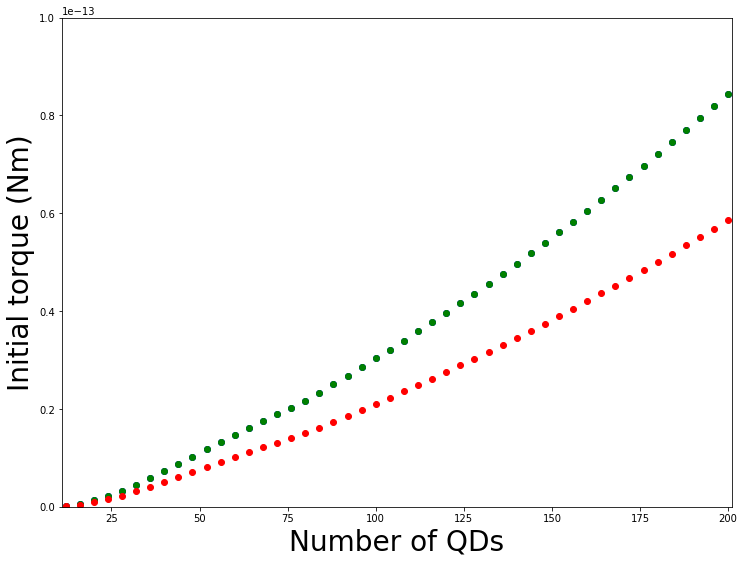

In [120]:
fig2 = plt.figure(figsize=(12, 9))
bx1 = fig2.add_subplot(111)
bx1.set_xlabel('Number of QDs', fontsize ='28')
bx1.set_ylabel('Initial torque (Nm)', fontsize ='28')
bx1.set_ylim( 0 , 1e-13 )
bx1.set_xlim( startN-1 , N )
bx2 = fig2.add_subplot(111)
bx3 = fig2.add_subplot(111)
bx_list = [bx1, bx2, bx3]

i=0
tor = []
for element in fluid_density_list:
    j=0
    tor = Tbig_list[i]
    for n in np.arange(startN, N, 4):
        tor2 = tor[j]
        bx_list[i].scatter(n, tor2[0] , color = color_list[i])
        j+=1
    i+=1

In [121]:
tor = Tbig_list[0]
tor2 = tor[17]
print (tor2[0])

2.1643298278e-14


In [122]:
i=0
snipped_solbig_list = []
for element in fluid_density_list:
    snipped_sol_list = []
    keep_j_list = []
    constant_list = []
    constant_list = material_constant_list[i]
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    G_list = []
    H_list = []
    J_list = []
    K_list = []
    L_list = []
    A_list = Abig_list[i]
    B_list = Bbig_list[i]
    C_list = Cbig_list[i]
    D_list = Dbig_list[i]
    E_list = Ebig_list[i]
    F_list = Fbig_list[i]
    G_list = Gbig_list[i]
    H_list = Hbig_list[i]
    J_list = Jbig_list[i]
    K_list = Kbig_list[i]
    L_list = Lbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        params = [ ( (constant_list[j]*(Rp_list[j]-(r_list[j]/4))/2)/(I_list[j]) ) , ( A_list[j]/(I_list[j]) ), ( B_list[j]/(I_list[j]) ), ( C_list[j]/(I_list[j]) ), (D_list[j]/(I_list[j]) ), ( E_list[j]/(I_list[j]) ), ( F_list[j]/(I_list[j]) ), ( G_list[j]/(I_list[j]) ), ( H_list[j]/(I_list[j]) ), ( J_list[j]/(I_list[j]) ), ( K_list[j]/(I_list[j]) ), (L_list[j]/(I_list[j]) ) ]
        tStop = 3
        tInc = 5e-5
        t_array = np.arange( 0, tStop, tInc)
        sol = odeint( solvr, [0,0], t_array, args=(params,) )
        keep_j = 0
        for z in np.arange( 0, len(t_array) ):
            if sol[z][0] >= step_list[j]:
                keep_j = z
                break
            else:
                keep_j = len(t_array)
        keep_j_list.append( keep_j )
        snipped_sol = np.zeros((keep_j, 2))
        snipped_sol = sol[:keep_j]
        snipped_sol_list.append( snipped_sol )
        j+=1
        print(n)
        print (len(t_array))
        print (keep_j)
    snipped_solbig_list.append( snipped_sol_list )
    i+=1

12
60000
60000
16
60000
119
20
60000
162
24
60000
60000
28
60000
39
32
60000
46
36
60000
77
40
60000
66
44
60000
35
48
60000
25
52
60000
18
56
60000
22
60
60000
53
64
60000
18
68
60000
22
72
60000
60000
76
60000
15
80
60000
16
84
60000
19
88
60000
26
92
60000
12
96
60000
12
100
60000
13
104
60000
14
108
60000
16
112
60000
18
116
60000
22
120
60000
40
124
60000
9
128
60000
9
132
60000
10
136
60000
10
140
60000
11
144
60000
11
148
60000
12
152
60000
12
156
60000
13
160
60000
14
164
60000
15
168
60000
16
172
60000
17
176
60000
20
180
60000
60000
184
60000
5
188
60000
5
192
60000
5
196
60000
6
200
60000
6
12
60000
60000
16
60000
111
20
60000
151
24
60000
60000
28
60000
36
32
60000
42
36
60000
71
40
60000
61
44
60000
32
48
60000
23
52
60000
17
56
60000
21
60
60000
49
64
60000
16
68
60000
20
72
60000
60000
76
60000
14
80
60000
15
84
60000
18
88
60000
24
92
60000
11
96
60000
11
100
60000
12
104
60000
13
108
60000
15
112
60000
17
116
60000
20
120
60000
37
124
60000
8
128
60000
9
132
60000
9
13

In [123]:
i=0
E_OUTbig_list = []
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    E_OUT_list = []
    A_list = []
    B_list = []
    C_list = []
    D_list = []
    E_list = []
    F_list = []
    G_list = []
    H_list = []
    J_list = []
    K_list = []
    L_list = []
    A_list = Abig_list[i]
    B_list = Bbig_list[i]
    C_list = Cbig_list[i]
    D_list = Dbig_list[i]
    E_list = Ebig_list[i]
    F_list = Fbig_list[i]
    G_list = Gbig_list[i]
    H_list = Hbig_list[i]
    J_list = Jbig_list[i]
    K_list = Kbig_list[i]
    L_list = Lbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        snip_sol = snipped_sol_list[j]
        E_OUT = 0
        for z in np.arange( 0, len(snip_sol) ):
            p_out = Output_power(snip_sol[z][1], func(snip_sol[z][0], A_list[j], B_list[j], C_list[j], D_list[j], E_list[j], F_list[j], G_list[j], H_list[j], J_list[j], K_list[j], L_list[j]) )
            E_OUT += p_out * tInc
        E_OUT_list.append( E_OUT )
        j+=1
        #print (n  ,  E_OUT)
    E_OUTbig_list.append( E_OUT_list )
    i+=1

In [124]:
"""Computes input power"""
Cdot = QD_capacitance( eps0, diam)
E_in_list = []
i=0
for n in np.arange(startN, N, 4):
    PCs = permanent_charges( Rp_list[i], p_list[i] , cap_d, cap_vol, width_list[i], r_list[i])
    E_in = Input_energy (n_list[i], e, Cdot, Rt, h, m_eeff, diam, E_g, m_heff, noc, cap_vol, R_c)
    E_in_list.append( E_in )
    i+=1


(12, 0.49088738802149773)
(16, 0.44347169699649558)
(20, 0.38841550058502178)
(24, 0.33700251965144618)
(28, 0.29007912609391595)
(32, 0.25336440459708187)
(36, 0.22097021767364142)
(40, 0.19335075671742566)
(44, 0.16985305319562899)
(48, 0.14927005607653984)
(52, 0.12950507156600127)
(56, 0.11791880818267893)
(60, 0.1063918514265909)
(64, 0.094111941116206535)
(68, 0.086148174217283213)
(72, 0.078557068457492912)
(76, 0.069265984869612482)
(80, 0.064005675447982163)
(84, 0.059502875253320001)
(88, 0.055074229141718674)
(92, 0.047307568601640274)
(96, 0.043923705137241996)
(100, 0.041706635075354777)
(104, 0.039446084368714794)
(108, 0.037470182356973837)
(112, 0.035397422098629359)
(116, 0.033443907228155899)
(120, 0.031556727115701767)
(124, 0.025576872583225121)
(128, 0.024355100763764514)
(132, 0.024238914479196391)
(136, 0.023151616227857889)
(140, 0.022746469903049737)
(144, 0.021795033623439181)
(148, 0.021298107450602882)
(152, 0.02046297392303496)
(156, 0.019915923932128366)
(

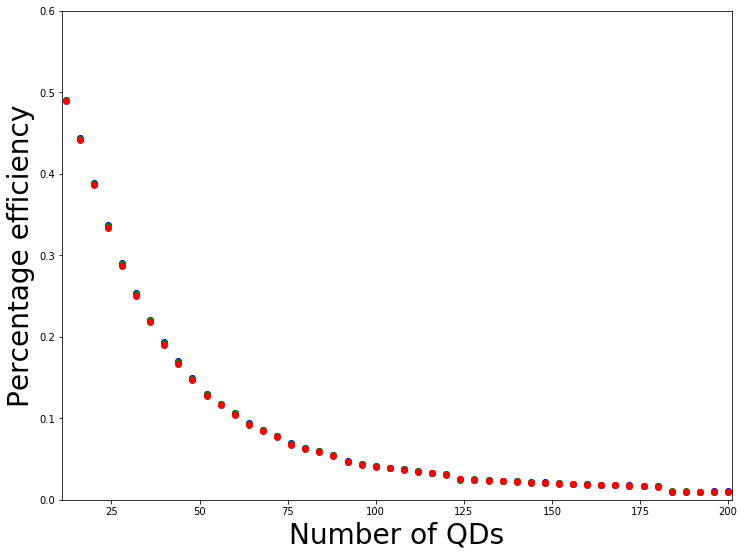

In [134]:
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(111)
ax1.set_xlabel('Number of QDs', fontsize ='28')
ax1.set_ylabel('Percentage efficiency', fontsize ='28')
ax1.set_ylim( 0 , 0.6)
ax1.set_xlim( startN-1 , N )
ax2 = fig1.add_subplot(111)
ax3 = fig1.add_subplot(111)
ax_list = [ax1, ax2, ax3]

i=0
for element in fluid_density_list:
    E_OUT_list = E_OUTbig_list[i]
    eff_percent_list = []
    j=0
    for n in np.arange(startN, N, 4):
        eff = efficiency( E_in_list[j], E_OUT_list[j] )
        print ( n, eff*100 )
        eff_percent_list.append( eff*100 )
        ax_list[i].scatter( n_list[j], eff_percent_list[j], color= color_list[i] )
        j+=1
    i+=1

In [126]:
i=0
for element in E_in_list:
    print ( E_in_list[i] )
    i+=1

1.46991827477e-14
3.66198417655e-14
6.84786095913e-14
1.10238405176e-13
1.61875637566e-13
2.23375963292e-13
2.94730409119e-13
3.75933141385e-13
4.6698022612e-13
5.67868922888e-13
6.78597267944e-13
7.99163819118e-13
9.29567494368e-13
1.06980746647e-12
1.21988309247e-12
1.37979386522e-12
1.54953937945e-12
1.72911930746e-12
1.91853338143e-12
2.11778138041e-12
2.32686312046e-12
2.54577844726e-12
2.77452723039e-12
3.01310935885e-12
3.26152473761e-12
3.51977328483e-12
3.78785492965e-12
4.06576961041e-12
4.3535172732e-12
4.65109787069e-12
4.95851136116e-12
5.27575770768e-12
5.60283687743e-12
5.9397488412e-12
6.28649357283e-12
6.64307104889e-12
7.00948124829e-12
7.38572415201e-12
7.77179974287e-12
8.16770800527e-12
8.57344892506e-12
8.98902248933e-12
9.41442868631e-12
9.84966750526e-12
1.02947389363e-11
1.07496429704e-11
1.12143795992e-11
1.1688948815e-11


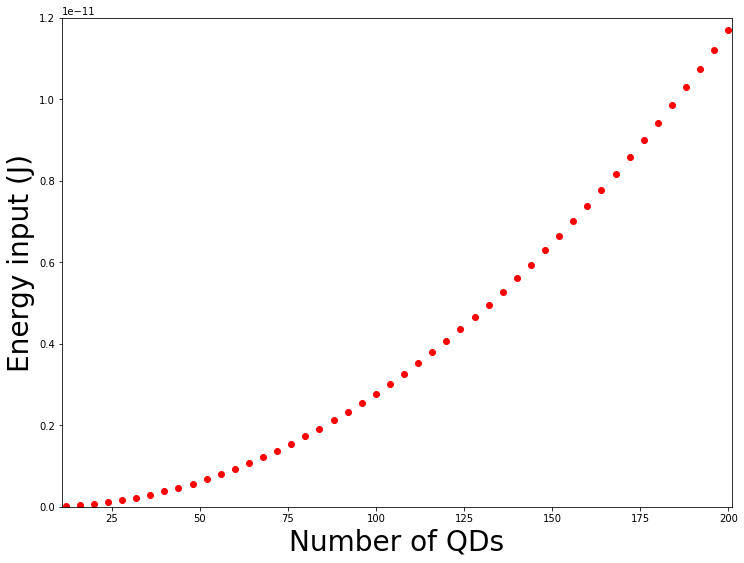

In [127]:
fig2 = plt.figure(figsize=(12, 9))
cx1 = fig2.add_subplot(111)
cx1.set_xlabel('Number of QDs', fontsize ='28')
cx1.set_ylabel('Energy input (J)', fontsize ='28')
cx1.set_ylim( 0 , 1.2e-11 )
cx1.set_xlim( startN-1 , N )
#cx2 = fig1.add_subplot(111)
#cx3 = fig1.add_subplot(111)
#cx_list = [ax1, ax2, ax3]

i=0
for n in np.arange(startN, N, 4):
    cx1.scatter( n_list[i], E_in_list[i], color = 'r' )
    i+=1

In [128]:
i=0
for element in fluid_density_list:
    j=0
    E_OUT_list = E_OUTbig_list[i]
    for n in np.arange(startN, N, 4):
        print ( E_OUT_list[j] )
        j+=1
    print ("fuck hayfever")
    i+=1

7.21564342509e-17
1.62398633715e-16
2.65981534238e-16
3.71506203067e-16
4.69567434812e-16
5.65955179407e-16
6.51266426581e-16
7.2686957362e-16
7.93180171885e-16
8.47658259636e-16
8.78817877496e-16
9.42364450932e-16
9.88984067518e-16
1.0068165729e-15
1.05090701174e-15
1.08392561127e-15
1.07330371212e-15
1.10673449204e-15
1.14158252465e-15
1.16635177017e-15
1.10078236698e-15
1.11820021862e-15
1.15716194704e-15
1.18855365981e-15
1.2220992668e-15
1.24590900655e-15
1.26680668861e-15
1.28302382111e-15
1.11349356586e-15
1.13277957303e-15
1.20188932827e-15
1.22142317759e-15
1.27444760404e-15
1.29457025709e-15
1.33890415602e-15
1.35936989642e-15
1.39600295345e-15
1.42728036958e-15
1.4552086384e-15
1.48091632379e-15
1.50500723395e-15
1.52989229958e-15
1.55120394737e-15
1.00091826942e-15
1.01949362336e-15
1.03805066326e-15
1.22345512056e-15
1.24383492972e-15
fuck hayfever
7.21130639335e-17
1.6222034699e-16
2.65538327988e-16
3.70688716718e-16
4.68184788726e-16
5.64102968386e-16
6.48938003234e-16
7

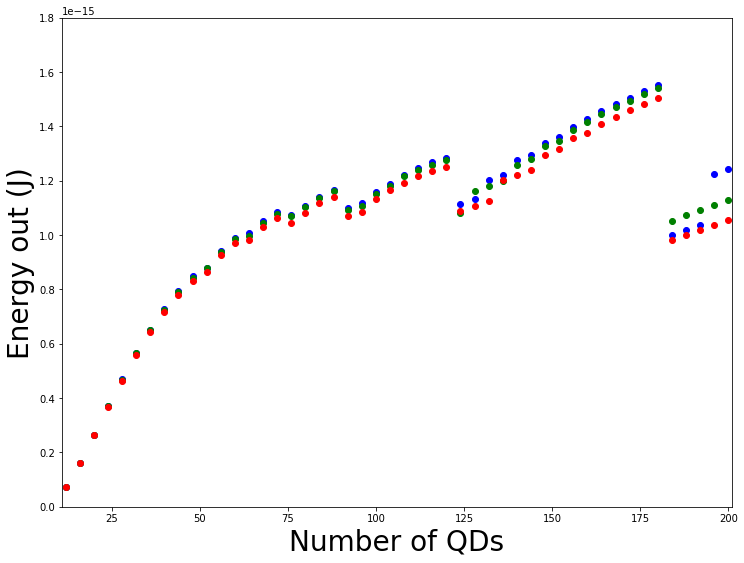

In [129]:
fig3 = plt.figure(figsize=(12, 9))
dx1 = fig3.add_subplot(111)
dx1.set_xlabel('Number of QDs', fontsize ='28')
dx1.set_ylabel('Energy out (J)', fontsize ='28')
dx1.set_ylim( 0 , 1.8e-15 )
dx1.set_xlim( startN-1 , N )
dx2 = fig3.add_subplot(111)
dx3 = fig3.add_subplot(111)
dx_list = [dx1, dx2, dx3]

i=0
for element in fluid_density_list:
    j=0
    E_OUT_list = E_OUTbig_list[i]
    for n in np.arange(startN, N, 4):
        dx_list[i].scatter( n_list[j], E_OUT_list[j], color = color_list[i] )
        j+=1
    i+=1

In [130]:
i=0
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        snip_sol = snipped_sol_list[j]
        maxw = np.max(snip_sol[1])
        print (n , maxw)
        j+=1
    i+=1

(12, 114.86120790126481)
(16, 152.45726836778914)
(20, 176.84816036144429)
(24, 190.18653558683951)
(28, 198.15817843334952)
(32, 200.1334862281831)
(36, 198.04342134127035)
(40, 194.69025560955612)
(44, 189.35513295785142)
(48, 182.78514414417234)
(52, 176.87516273521936)
(56, 169.2774562112582)
(60, 162.60485086550847)
(64, 154.57624530421995)
(68, 147.87784793957229)
(72, 140.84910038114663)
(76, 135.77992417823074)
(80, 131.05715431814983)
(84, 125.60116206226222)
(88, 121.82158151492)
(92, 118.77328272247929)
(96, 116.03917096721476)
(100, 113.37731124861935)
(104, 110.78371660915371)
(108, 107.5244320676684)
(112, 105.23440498422737)
(116, 103.10311010906912)
(120, 101.11021719956152)
(124, 99.210583075557011)
(128, 97.392903743444762)
(132, 95.675111112260126)
(136, 94.044054781691415)
(140, 91.824340468566135)
(144, 90.353334644527322)
(148, 88.954917042421172)
(152, 87.626386442950746)
(156, 86.360222636066652)
(160, 85.146343401682685)
(164, 83.984086463568431)
(168, 82.87202

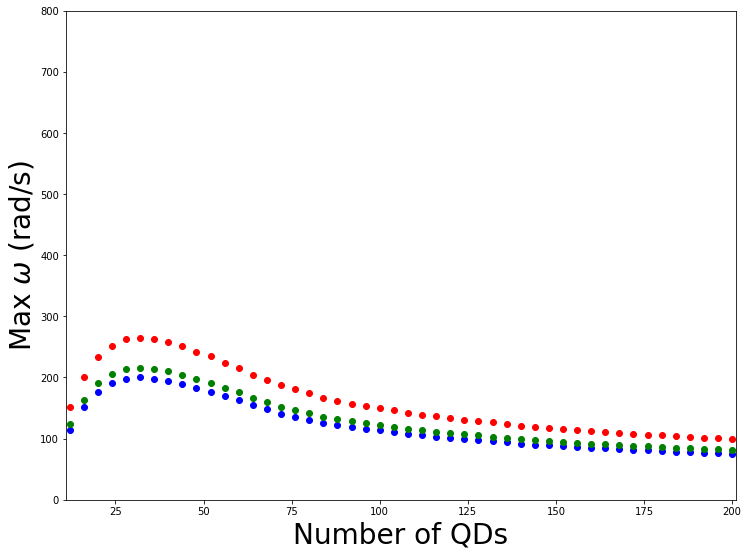

In [131]:
fig4 = plt.figure(figsize=(12, 9))
ex1 = fig4.add_subplot(111)
ex1.set_xlabel('Number of QDs', fontsize ='28')
ex1.set_ylabel('Max $\omega$ (rad/s)', fontsize ='28')
ex1.set_ylim( 0 , 800)
ex1.set_xlim( startN-1 , N )
ex2 = fig4.add_subplot(111)
ex3 = fig4.add_subplot(111)
ex_list = [ex1, ex2, ex3]
i=0
for element in fluid_density_list:
    snipped_sol_list = snipped_solbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        snip_sol = snipped_sol_list[j]
        maxw = np.max(snip_sol[1])
        ex_list[i].scatter( n_list[j], maxw, color = color_list[i] )
        j+=1
    i+=1

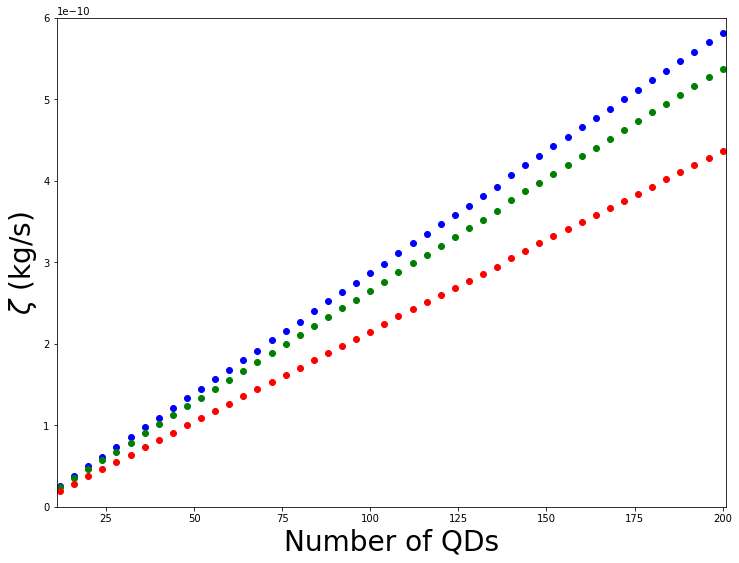

In [132]:
fig5 = plt.figure(figsize=(12, 9))
fx1 = fig5.add_subplot(111)
fx1.set_xlabel('Number of QDs', fontsize ='28')
fx1.set_ylabel('$\zeta$ (kg/s)', fontsize ='28')
fx1.set_ylim( 0 , 0.6e-9)
fx1.set_xlim( startN-1 , N )
fx2 = fig5.add_subplot(111)
fx3 = fig5.add_subplot(111)
fx_list = [fx1, fx2, fx3]
i=0
for element in fluid_density_list:
    const = material_constant_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        constant = const[j]
        fx_list[i].scatter( n_list[j], constant, color = color_list[i] )
        j+=1
    i+=1

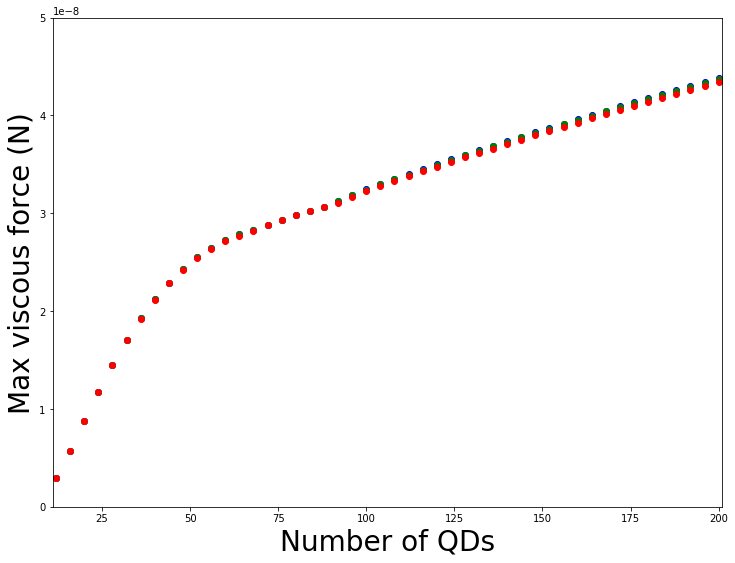

In [133]:
fig6 = plt.figure(figsize=(12, 9))
gx1 = fig6.add_subplot(111)
gx1.set_xlabel('Number of QDs', fontsize ='28')
gx1.set_ylabel('Max viscous force (N)', fontsize ='28')
gx1.set_ylim( 0 , 5e-8)
gx1.set_xlim( startN-1 , N )
gx2 = fig6.add_subplot(111)
gx3 = fig6.add_subplot(111)
gx_list = [gx1, gx2, gx3]
i=0
for element in fluid_density_list:
    const = material_constant_list[i]
    snipped_sol_list = snipped_solbig_list[i]
    j=0
    for n in np.arange(startN, N, 4):
        constant = const[j]
        snip_sol = snipped_sol_list[j]
        maxw = np.max(snip_sol[1])
        #print (constant*maxw)
        gx_list[i].scatter( n_list[j], constant*maxw , color = color_list[i] )
        j+=1
    i+=1